In [21]:
# @author: vitorvilasboas
!pip install mne
import mne
import itertools
import warnings
import numpy as np
from time import time
from scipy.fftpack import fft
from scipy.linalg import eigh
from scipy.signal import butter, lfilter
from sklearn.svm import SVC
from scipy.io import loadmat
from scipy.stats import norm
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt 


def extractEpochs(data, events, smin, smax, class_ids):
    events_list = events[:, 1] # get class labels column
    cond = False
    for i in range(len(class_ids)): cond += (events_list == class_ids[i]) #get only class_ids pos in events_list
    idx = np.where(cond)[0]
    s0 = events[idx, 0] # get initial timestamps of each class epochs
    sBegin = s0 + smin
    sEnd = s0 + smax
    n_epochs = len(sBegin)
    n_channels = data.shape[0]
    n_samples = smax - smin
    epochs = np.zeros([n_epochs, n_channels, n_samples])
    labels = events_list[idx]
    bad_epoch_list = []
    for i in range(n_epochs):
        epoch = data[:, sBegin[i]:sEnd[i]]
        if epoch.shape[1] == n_samples: epochs[i, :, :] = epoch # Check if epoch is complete
        else:
            print('Incomplete epoch detected...', n_samples, '!=', epoch.shape[1])
            bad_epoch_list.append(i)
    labels = np.delete(labels, bad_epoch_list)
    epochs = np.delete(epochs, bad_epoch_list, axis=0)
    return epochs, labels
  
def nanCleaner(epoch):
    """Removes NaN from data by interpolation
    data_in : input data - np matrix channels x samples
    data_out : clean dataset with no NaN samples"""
    for i in range(epoch.shape[0]):
        bad_idx = np.isnan(epoch[i, :])
        epoch[i, bad_idx] = np.interp(bad_idx.nonzero()[0], (~bad_idx).nonzero()[0], epoch[i, ~bad_idx])
    return epoch

class Filter:
    def __init__(self, fl, fh, Fs, filtering, band_type='bandpass'):
        self.ftype = filtering['design']
        if self.ftype != 'DFT':
            nyq = 0.5*Fs
            low = fl/nyq
            high = fh/nyq        
            if low == 0: low = 0.001
            if high >= 1: high = 0.99
            if self.ftype == 'IIR':
                # self.b, self.a = iirfilter(filtering['iir_order'], [low, high], btype='band')
                self.b, self.a = butter(filtering['iir_order'], [low, high], btype=band_type)
            elif self.ftype == 'FIR':
                self.b, self.a = firwin(filtering['fir_order'], [low, high], window='hamming', pass_zero=False), [1]

    def apply_filter(self, X, is_epoch=False):
        if self.ftype != 'DFT': XF = lfilter(self.b, self.a, X) # lfilter, filtfilt
        else:
            XF = fft(X)
            if is_epoch:
                real, imag = np.real(XF).T, np.imag(XF).T
                XF = np.transpose(list(itertools.chain.from_iterable(zip(imag, real))))
            else:
                real = np.transpose(np.real(XF), (2, 0, 1))
                imag = np.transpose(np.imag(XF), (2, 0, 1))
                XF = np.transpose(list(itertools.chain.from_iterable(zip(imag, real))), (1, 2, 0)) 
        return XF

class CSP:
    def __init__(self, n_components):
        self.n_components = n_components
        self.filters_ = None
    def fit(self, X, t):
        ch = X.shape[1]
        class_ids = np.unique(t)   
        X1 = X[class_ids[0] == t]
        X2 = X[class_ids[1] == t]
        S1, S2 = np.zeros((ch, ch)), np.zeros((ch, ch))  
        for i in range(len(X1)): S1 += np.dot(X1[i], X1[i].T) / X1[i].shape[-1] # cov X[i]
        for i in range(len(X2)): S2 += np.dot(X2[i], X2[i].T) / X2[i].shape[-1] # ...sum((X*X.T)/q)
        S1 /= len(X1); 
        S2 /= len(X2)
        [D, W] = eigh(S1, S1 + S2) # + 1e-10 * np.eye(22))
        ind = np.empty(ch, dtype=int)
        ind[0::2] = np.arange(ch-1, ch//2 - 1, -1) 
        ind[1::2] = np.arange(0, ch//2)
        # W += 1e-1 * np.eye(22)
        W = W[:, ind]
        self.filters_ = W.T[:self.n_components]
        return self # used on cross-validation pipeline
    def transform(self, X):        
        Y = np.asarray([np.dot(self.filters_, ep) for ep in X])
        # FEAT = np.log(np.mean(Y**2, axis=2))
        FEAT = np.log(np.var(Y, axis=2))
        return FEAT

from google.colab import drive
drive.mount('/content/drive')

# import sys
# sys.path.append('/content/drive/My Drive/BCI_workgroup')
# from bci_utils import nanCleaner, extractEpochs, Filter, CSP

warnings.filterwarnings("ignore", category=DeprecationWarning)
mne.set_log_level(50, 50)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


50

In [22]:
# Fs = 250
# windows = []
# for i,j in zip(range(0.5, 3, 0.5), range(1.5, 4, 0.5)):
# for i in zip(range(0.5, 3, 0.5):
#   for j in zip(range(1.5, 4, 0.5):
      # smin, smax = int(i*Fs), int(j*Fs)
      # class_ids = [1,2]
      # windows.append([i,j])
# print(windows)

Fs = 250
smin, smax = int(0.5*Fs), int(2.5*Fs)
class_ids = [1,2,3,4]
suj = 1

In [32]:
### to gdf file
eeg = mne.io.read_raw_gdf('/content/drive/My Drive/BCI_workgroup/dataset/IV2a/A0' + str(suj) + 'T.gdf').load_data()
data = eeg.get_data()[:22] # [channels x samples]
events = mne.events_from_annotations(eeg) # raw.find_edf_events()
ch_names = eeg.ch_names

for k,v in events[1].items(): print(f'{k}:: {v}')
lb_utils = [7,8,9,10]
events = np.delete(events[0], 1, axis=1)

ZT, tt = extractEpochs(data, events, smin, smax, lb_utils)
for i,k in zip(lb_utils, range(1, 5)): tt = np.where(tt == i, k, tt)
ZT = np.vstack([ ZT[np.where(tt == k)] for k in class_ids ])
tt = np.hstack([ np.ones(len(ZT)//2)*k for k in class_ids ]).astype(int) 
# np.concatenate(ZT, axis=-1)

print(ZT.shape)
print(tt.shape)

1023:: 1
1072:: 2
276:: 3
277:: 4
32766:: 5
768:: 6
769:: 7
770:: 8
771:: 9
772:: 10
(288, 22, 500)
(576,)


In [24]:
### to gdf file
eeg = mne.io.read_raw_gdf('/content/drive/My Drive/BCI_workgroup/dataset/IV2a/A0'+ str(suj) +'E.gdf').load_data()
data = eeg.get_data()[:22] # [channels x samples]
events = mne.events_from_annotations(eeg) # raw.find_edf_events()
ch_names = eeg.ch_names

for k,v in events[1].items(): print(f'{k}:: {v}')
lb_utils = [7]
events = np.delete(events[0], 1, axis=1)

ZV, _ = extractEpochs(data, events, smin, smax, [7])
tv = np.ravel(loadmat('/content/drive/My Drive/BCI_workgroup/dataset/IV2a/true_labels/A0'+ str(suj) +'E.mat')['classlabel'])
ZV = np.vstack([ ZV[np.where(tv == k)] for k in class_ids ])
tv = np.hstack([ np.ones(len(ZV)//2)*k for k in class_ids ]).astype(int)

print(ZV.shape)

1023:: 1
1072:: 2
276:: 3
277:: 4
32766:: 5
768:: 6
783:: 7
(288, 22, 500)


In [25]:
ch_names

['EEG-Fz',
 'EEG-0',
 'EEG-1',
 'EEG-2',
 'EEG-3',
 'EEG-4',
 'EEG-5',
 'EEG-C3',
 'EEG-6',
 'EEG-Cz',
 'EEG-7',
 'EEG-C4',
 'EEG-8',
 'EEG-9',
 'EEG-10',
 'EEG-11',
 'EEG-12',
 'EEG-13',
 'EEG-14',
 'EEG-Pz',
 'EEG-15',
 'EEG-16',
 'EOG-left',
 'EOG-central',
 'EOG-right']

In [26]:
fl, fh, ncsp, nbands = 4, 40, 8, 9
filtering = 'DFT' # DFT ou IIR

In [30]:
# t0 = time()
step = (fh-fl) / (nbands+1) # n_bins/nbands+1
size = step / 0.5 # step/overlap
sub_bands = []
for i in range(nbands):
    fl_sb = i * step + fl
    fh_sb = i * step + size + fl
    sub_bands.append([fl_sb, fh_sb])

In [28]:
## Filtragem temporal
XT, XV = [], []
if filtering == 'DFT':
    filt = Filter(fl, fh, Fs, {'design':'DFT'})
    XTF = filt.apply_filter(ZT)
    XVF = filt.apply_filter(ZV)
    for i in range(nbands):
        bsize = 2/(Fs/ZT.shape[-1]) # 2 == sen/cos
        XT.append(XTF[:, :, round(sub_bands[i][0]*bsize):round(sub_bands[i][1]*bsize)])
        bsize = 2/(Fs/ZV.shape[-1])
        XV.append(XVF[:, :, round(sub_bands[i][0]*bsize):round(sub_bands[i][1]*bsize)])         
elif filtering == 'IIR':
    for i in range(nbands):
        filt = Filter(sub_bands[i][0], sub_bands[i][1], Fs, {'design':'IIR', 'iir_order':5})
        XT.append(filt.apply_filter(ZT))
        XV.append(filt.apply_filter(ZV))

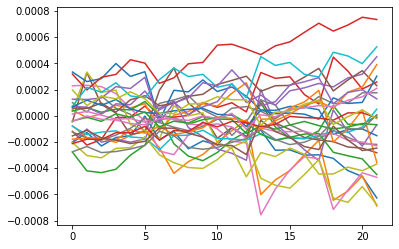

In [ ]:
plt.figure()
plt.plot(XT[2][1,:,:])
plt.show()

In [ ]:
# 9 x 144 x 22 x 500

In [29]:
## Filtragem espacial
csp = [ CSP(n_components=ncsp) for i in range(nbands) ] #mne.decoding.CSP()
for i in range(nbands): csp[i].fit(XT[i], tt)
FT = [ csp[i].transform(XT[i]) for i in range(nbands) ]
FV = [ csp[i].transform(XV[i]) for i in range(nbands) ]

IndexError: ignored

In [ ]:
## Pontuações LDA
ldas = [ LDA() for i in range(nbands) ] 
for i in range(nbands): ldas[i].fit(FT[i], tt)
ST = np.asarray([ np.ravel(ldas[i].transform(FT[i])) for i in range(nbands)]).T # Score LDA
SV = np.asarray([ np.ravel(ldas[i].transform(FV[i])) for i in range(nbands)]).T 

In [ ]:
## FUSÃO DE PONTUAÇÕES
p0 = norm(np.mean(ST[tt == class_ids[0], :], axis=0), np.std(ST[tt == class_ids[0], :], axis=0))
p1 = norm(np.mean(ST[tt == class_ids[1], :], axis=0), np.std(ST[tt == class_ids[1], :], axis=0))
META_ST = np.log(p0.pdf(ST) / p1.pdf(ST))
META_SV = np.log(p0.pdf(SV) / p1.pdf(SV))

In [ ]:
## 
svm = SVC(kernel='linear', C=1e-4, probability=True)
svm.fit(META_ST, tt)
y, yp = svm.predict(META_SV), svm.predict_proba(META_SV); 
acc_svm = round(np.mean(y == tv)*100,2) # round(svm.score(META_SV, tv)*100,2)
print('SVM acc:', acc_svm)

# [filt, csp, lda,  p0, p1,svm]
# XV.append(filt.apply_filter(ZV))
# FV = [ csp[i].transform(XV[i]) for i in range(nbands) ]
# SV = np.asarray([ np.ravel(ldas[i].transform(FV[i])) for i in range(nbands)]).T 
# META_SV = np.log(p0.pdf(SV) / p1.pdf(SV))
# svm.predict(META_SV)

SVM acc: 79.17


In [ ]:
lda = LDA()
lda.fit(META_ST, tt)
y, yp = lda.predict(META_SV), lda.predict_proba(META_SV)
acc_lda = round(np.mean(y == tv)*100,2) # round(lda.score(META_SV, tv)*100,2)
print('LDA acc:', acc_lda)

LDA acc: 72.92


In [ ]:
TT, TV = np.zeros((len(ZT), 2)), np.zeros((len(ZV), 2))
for i in range(2): TT[:,i] = np.where(tt == i+1, 1, TT[:,i])
for i in range(2): TV[:,i] = np.where(tv == i+1, 1, TV[:,i])

mlp = MLPClassifier(hidden_layer_sizes=(100,2), max_iter=10000, activation='tanh', verbose=False) #, random_state=42)
mlp.out_activation = 'softmax' # 'logistic', 'softmax', # mlp.outputs = 3
mlp.fit(META_ST, TT)
Y, YP = mlp.predict(META_SV), mlp.predict_proba(META_SV)
y = np.argmax(YP, axis=1)+1
acc_mlp = round(np.mean(y == tv)*100,2) # round(mlp.score(META_SV, TV)*100,2)
print('MLP acc:', acc_mlp)



MLP acc: 77.78


In [ ]:
META_ST.shape

(144, 9)

In [ ]:
TT